<h1>Neural Collaborative Filtering</h1>

In [115]:
import sys
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k,  
                                                     recall_at_k, get_top_k_items)

import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import numpy as np

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas version: 1.5.3
Tensorflow version: 2.11.0


<h1>Load the dataset</h1>

In [116]:
def load(dataset_name):
    train_file = "../data/{}/train.csv".format(dataset_name)
    test_file = "../data/{}/test.csv".format(dataset_name)

    train = pd.read_csv(train_file)
    test  = pd.read_csv(test_file)

    #plt.figure(figsize=(14, 3))
    #train['rating'].hist()

    if dataset_name == 'movielens' or dataset_name == 'goodreads':
        train['rating'] /= 5
        test['rating'] /=5
    elif dataset_name == 'sas':
        train['rating'] = 1
        test['rating'] = 1

    train_file = '../data/{}/train_tmp.csv'.format(dataset_name)
    test_file = '../data/{}/test_tmp.csv'.format(dataset_name)

    train.to_csv(train_file)
    test.to_csv(test_file)

    binary_setting=False
    if dataset_name=='steam' or dataset_name=='sas':
        binary_setting=True

    data = NCFDataset(train_file=train_file, test_file=test_file, seed=42, binary=binary_setting)
    return train, test, data

<h1>Train the NCF model on the training data, and get the top-k recommendations for our testing data</h1>

- NCF accepts implicit feedback and generates prospensity of items to be recommended to users in the scale of 0 to 1
- A recommended item list can then be generated based on the scores

In [141]:
def init_NCF(data, epochs=2, factors=48):
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="NeuMF",
        n_factors=factors,
        layer_sizes=[16,8,4],
        n_epochs=epochs,
        batch_size=256,
        learning_rate=1e-3,
        verbose=1,
        seed=42
    )
    return model

In [171]:
class NCF_recsys():
    def __init__(self, name='sas'):

        self.dataset_name = name
        
        self.train, self.test, self.data = load(name)

        epochs = {
            'movielens': 15,
            'steam': 3,
            'goodreads': 6,
            'sas': 10,
        }
        factors = {
            'movielens': 48,
            'steam': 48,
            'goodreads': 48,
            'sas': 48,
        }
        self.model = init_NCF(self.data, epochs[name], factors[name])

    def fit(self):
        with Timer() as train_time:
            self.model.fit(self.data)

        print("Took {} seconds for training.".format(train_time))


    def get_top_n_recommendations(self, user_id, n=100):
        import numpy as np

        item_ids = np.arange(self.model.n_items)
        user_ids = np.full(self.model.n_items, user_id, dtype=np.int32)
        
        scores = np.array(self.model.predict(user_ids, item_ids, is_list=True))
        top_n_indices = np.argsort(scores)[-n:]  # Get the indices of the top N items
        
        return item_ids[top_n_indices], scores[top_n_indices]
    
    #######################
    def map_k(self, data_true, data_pred, K):
        return map_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def ndcg_k(self, data_true, data_pred, K):
        return ndcg_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def precision_k(self, data_true, data_pred, K):
        return precision_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def recall_k(self, data_true, data_pred, K):
        return recall_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)
    
    def inference(self):

        with Timer() as inference_time:
            from tqdm import tqdm

            users, items, preds = [], [], []

            for user in tqdm(self.train.userID.unique()):
                item, score = self.get_top_n_recommendations(user, 100)
                user = [user] * len(item)

                users.extend(user)
                items.extend(item)
                preds.extend(score)

        print("Took {} seconds for prediction.".format(inference_time))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})
        return all_predictions
    
    def get_all_scores(self):
        from tqdm import tqdm

        # all predictions
        top_k_df = self.inference()
        # exclude seen items
        top_ex = pd.merge(self.train, top_k_df, on=["userID", "itemID"], how="outer")
        top_ex = top_ex[top_ex.rating.isnull()].drop('rating', axis=1)

        test_df = self.test

        exc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [self.map_k(test_df, top_ex, 5), self.map_k(test_df, top_ex, 10), self.map_k(test_df, top_ex, 50)],
            'NDCG': [self.ndcg_k(test_df, top_ex, 5), self.ndcg_k(test_df, top_ex, 10), self.ndcg_k(test_df, top_ex, 50)],
            'Precision': [self.precision_k(test_df, top_ex, 5), self.precision_k(test_df, top_ex, 10), self.precision_k(test_df, top_ex, 50)],
            'Recall': [self.recall_k(test_df, top_ex, 5), self.recall_k(test_df, top_ex, 10), self.recall_k(test_df, top_ex, 50)],
        })

        inc_seen_rank = pd.DataFrame({
            'TOP_K': [5, 10, 50],
            'MAP': [self.map_k(test_df, top_k_df, 5), self.map_k(test_df, top_k_df, 10), self.map_k(test_df, top_k_df, 50)],
            'NDCG': [self.ndcg_k(test_df, top_k_df, 5), self.ndcg_k(test_df, top_k_df, 10), self.ndcg_k(test_df, top_k_df, 50)],
            'Precision': [self.precision_k(test_df, top_k_df, 5), self.precision_k(test_df, top_k_df, 10), self.precision_k(test_df, top_k_df, 50)],
            'Recall': [self.recall_k(test_df, top_k_df, 5), self.recall_k(test_df, top_k_df, 10), self.recall_k(test_df, top_k_df, 50)],
        })

        print('Rating predicting...')

        predictions = []
        for z, (u, i, r, t) in tqdm(self.test.iterrows(), total=self.test.shape[0]):
            try:
                prediction = self.model.predict(int(u), int(i))
            except:
                prediction = 0
            predictions.append(prediction)

        pred = deepcopy(self.test)
        pred = pred.drop('rating', axis=1)
        pred['prediction'] = predictions

        data_true=self.test
        data_pred=pred

        if self.dataset_name == 'movielens' or self.dataset_name == 'goodreads':
            data_pred['prediction'] *= 5
            data_true['rating'] *= 5

        eval_rmse = rmse(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
        eval_mae = mae(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
        eval_exp_var = exp_var(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")
        eval_rsquared = rsquared(data_true, data_pred, col_user="userID", col_item="itemID", col_rating="rating", col_prediction="prediction")

        inc_seen_rait = pd.DataFrame({
            'RMSE': [eval_rmse],
            'MAE': [eval_mae],
            'Exp Var': [eval_exp_var],
            'R squared': [eval_rsquared]
        })

        return exc_seen_rank, inc_seen_rank, inc_seen_rait

<h1>Evaluate how well NCF performs</h1>

In [172]:
def full_train(ds_name):
    als_recsys = NCF_recsys(ds_name)
    als_recsys.fit()
    return als_recsys.get_all_scores()

In [173]:
exc_seen_rank, inc_seen_rank, inc_seen_rait = full_train('steam')

INFO:recommenders.models.ncf.dataset:Indexing ../data/steam/train_tmp.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ../data/steam/test_tmp.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ../data/steam/test_tmp_full.csv ...
100%|██████████| 24752/24752 [00:15<00:00, 1567.38it/s]
901it [00:15, 56.95it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [15.82s]: train_loss = 0.378367 
100%|██████████| 24752/24752 [00:15<00:00, 1624.28it/s]
901it [00:15, 59.03it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [15.26s]: train_loss = 0.300032 
100%|██████████| 24752/24752 [00:15<00:00, 1618.60it/s]
901it [00:15, 58.83it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [15.32s]: train_loss = 0.220261 
100%|██████████| 24752/24752 [00:15<00:00, 1629.48it/s]
901it [00:15, 59.23it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [15.21s]: train_loss = 0.123498 
100%|██████████| 24752/24752 [00:15<00:00, 1621.57it/s]
901it [00:15, 58.94it/s]
INFO:recommenders.

Took 107.6771 seconds for training.


100%|██████████| 24752/24752 [00:37<00:00, 667.44it/s]


Took 37.0862 seconds for prediction.
Rating predicting...


100%|██████████| 8817/8817 [00:02<00:00, 3782.19it/s]


In [174]:
exc_seen_rank.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_20749/3256864183.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  exc_seen_rank.style.hide_index()


TOP_K,MAP,NDCG,Precision,Recall
5,0.054668,0.067289,0.022865,0.093229
10,0.059369,0.079119,0.015784,0.127846
50,0.065398,0.108637,0.006396,0.254841


In [175]:
inc_seen_rank.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_20749/1931737838.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  inc_seen_rank.style.hide_index()


TOP_K,MAP,NDCG,Precision,Recall
5,0.025274,0.036395,0.015135,0.066018
10,0.032348,0.054401,0.014294,0.118095
50,0.039060,0.086920,0.006435,0.257049


In [176]:
inc_seen_rait.style.hide_index()

/var/folders/p5/jqpndw0d2cg7g0mst1n0c49r0000gn/T/ipykernel_20749/3271275326.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  inc_seen_rait.style.hide_index()


RMSE,MAE,Exp Var,R squared
0.870477,0.793690,-0.458661,-6.353539


<h3>SAS RFM</h3>

In [111]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

INFO:recommenders.models.ncf.dataset:Indexing ../data/sas/train_tmp.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ../data/sas/test_tmp.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ../data/sas/test_tmp_full.csv ...
100%|██████████| 47759/47759 [00:33<00:00, 1446.22it/s]
3213it [00:33, 97.26it/s] 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [33.04s]: train_loss = 0.454617 
100%|██████████| 47759/47759 [00:32<00:00, 1463.88it/s]
3213it [00:32, 98.45it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [32.64s]: train_loss = 0.375897 
100%|██████████| 47759/47759 [00:33<00:00, 1443.04it/s]
3213it [00:33, 97.05it/s]
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [33.11s]: train_loss = 0.283185 


Took 98.7847 seconds for training.


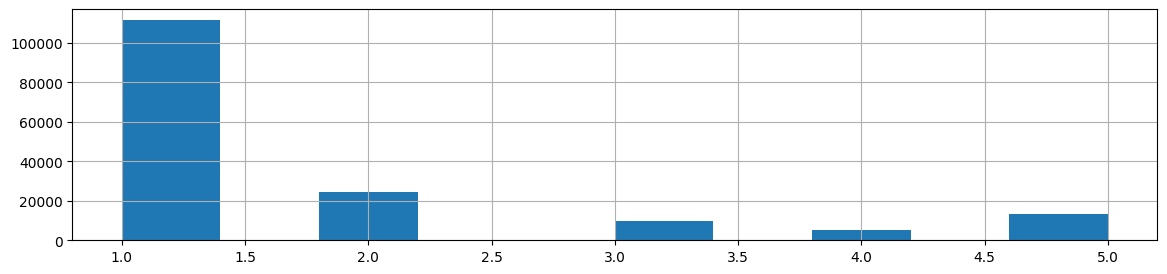

In [105]:
als_recsys = NCF_recsys('sas')
als_recsys.fit()

In [107]:
# all predictions
top_k_df = als_recsys.inference()
# exclude seen items
top_ex = pd.merge(als_recsys.train, top_k_df, on=["userID", "itemID"], how="outer")
top_ex = top_ex[top_ex.rating.isnull()].drop('rating', axis=1)

100%|██████████| 47759/47759 [02:01<00:00, 394.24it/s]


Took 121.1257 seconds for prediction.


In [108]:
merged_pred = deepcopy(top_ex)
merged_test = deepcopy(als_recsys.test)

In [109]:
ndcg_at_k(merged_test, merged_pred, col_prediction='prediction', k=10)

0.04733723480398613

In [112]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(5806, 4) (555251, 4)
(3557, 4) (570602, 4)
(4122, 4) (838708, 4)
(4400, 4) (1156086, 4)
(2720, 4) (1010933, 4)
(574, 4) (383308, 4)


In [113]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.0377
Champions 0.0411
Loyal 0.0481
Potential 0.0426
Sleeping 0.0524
Require Activation 0.0785


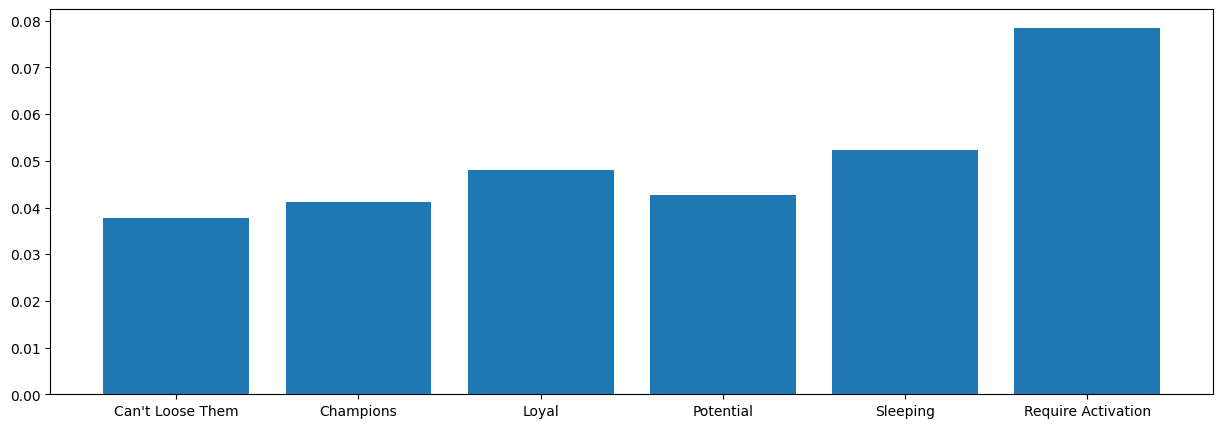

In [114]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);